In [17]:
# 필요한 라이브러리 임포트
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import torch.nn as nn
import numpy as np
import pandas as pd

from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

# GPU 설정 (A5000 GPU 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
!nvidia-smi

Device: cuda
Sun Nov 17 22:38:27 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.28.03              Driver Version: 560.28.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               Off |   00000000:01:00.0 Off |                  Off |
| 30%   33C    P8              9W /  230W |    6430MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------------------------

In [16]:
# 레이블 인코딩 (항목 열을 숫자로 변환)
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('simple_field.csv')

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['항목'])

# 레이블과 인코딩된 값 출력
print("레이블 인코딩 결과:")
for label, index in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{label}: {index}")

# 학습 데이터와 테스트 데이터로 분할 (stratify로 레이블 분포 유지)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['대화'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

df.tail(4)

레이블 인코딩 결과:
가정폭력: 0
방임: 1
성학대: 2
신체학대: 3
자해/자살: 4
정서학대: 5
트라우마: 6
학교폭력: 7
해당없음: 8


,항목,대화,label
5476,자해/자살,Q: 우리 친구는 어떨 때 마음이 복잡하거나 힘들어? A: 엄마가 저 죽어버렸으면 ...,4
5477,방임,Q: 집에서 주로 나를 돌봐주는 사람은 누구인가요? A: 돌봐주는 사람은 없는 것 ...,1
5478,트라우마,Q: 평소에 잠이 들기 힘들거나 잠자는 중간에 자주 깨니? A: 악몽을 꾸다가 깬 ...,6
5479,신체학대,Q: 주위 어른이나 가족들 중에 친구를 때렸던 사람이 있어? A: 아빠가 때렸다고 ...,3


In [ ]:
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "monologg/kobert", num_labels=len(label_encoder.classes_))
tokenizer = AutoTokenizer.from_pretrained(
    "monologg/kobert", trust_remote_code=True)
model.to(device)

# 커스텀 데이터셋 클래스 정의


class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # 텍스트를 토크나이즈하고 텐서로 변환
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long),
        }


# 데이터로더 생성
train_dataset = CustomDataset(train_texts, train_labels, tokenizer)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:

# 옵티마이저와 스케줄러 설정
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 3  # 총 학습 스텝

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# 손실 함수 정의 (CrossEntropyLoss)
loss_fn = nn.CrossEntropyLoss().to(device)

# 학습 함수 정의


def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()

    losses = []
    correct_preds = 0

    for batch in data_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_preds += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), max_norm=1.0)  # 그래디언트 클리핑
        optimizer.step()
        scheduler.step()

    return correct_preds.double() / len(data_loader.dataset), np.mean(losses)

# 평가 함수 정의


def eval_model(model, data_loader, loss_fn, device):
    model.eval()

    losses = []
    correct_preds = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_preds += torch.sum(preds == labels)
            losses.append(loss.item())

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return correct_preds.double() / len(data_loader.dataset), np.mean(losses), predictions, true_labels

In [ ]:

# 학습 및 평가 루프
EPOCHS = 5  # 에폭 수

for epoch in range(EPOCHS):
    print(f'에폭 {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler
    )

    print(f'훈련 손실 {train_loss:.4f}, 정확도 {train_acc:.4f}')

    val_acc, val_loss, _, _ = eval_model(
        model,
        test_loader,
        loss_fn,
        device
    )

    print(f'검증 손실 {val_loss:.4f}, 정확도 {val_acc:.4f}')

에폭 1/5
----------
훈련 손실 0.8032, 정확도 0.8239
검증 손실 0.2154, 정확도 0.9580
에폭 2/5
----------
훈련 손실 0.1867, 정확도 0.9578
검증 손실 0.1659, 정확도 0.9617
에폭 3/5
----------
훈련 손실 0.1318, 정확도 0.9662
검증 손실 0.1412, 정확도 0.9690
에폭 4/5
----------
훈련 손실 0.1093, 정확도 0.9749
검증 손실 0.1412, 정확도 0.9690
에폭 5/5
----------
훈련 손실 0.1106, 정확도 0.9735
검증 손실 0.1412, 정확도 0.9690


In [6]:
# Save paths
from datetime import datetime

cur_time_str = datetime.now().strftime("%Y%m%d%H%M%S")
model_save_path = f'model_{cur_time_str}/'

# Save the trained model
model.save_pretrained(model_save_path)
print("Model saved successfully.")

Model saved successfully.


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_save_path, num_labels=len(label_encoder.classes_))
tokenizer = AutoTokenizer.from_pretrained(
    "monologg/kobert", trust_remote_code=True)
model.to(device)

# 테스트 데이터에서 모델 평가
test_acc, test_loss, y_pred, y_true = eval_model(
    model,
    test_loader,
    loss_fn,
    device
)

print(f'테스트 손실 {test_loss:.4f}, 정확도 {test_acc:.4f}')

# 분류 리포트 생성 (정밀도, 재현율 등)
print('\n분류 리포트:')
print(classification_report(y_true, y_pred,
      target_names=label_encoder.classes_, digits=4))

테스트 손실 0.1412, 정확도 0.9690

분류 리포트:
              precision    recall  f1-score   support

        가정폭력     0.9853    0.9571    0.9710        70
          방임     0.9495    0.9126    0.9307       103
         성학대     1.0000    1.0000    1.0000        58
        신체학대     1.0000    0.9771    0.9884       131
       자해/자살     0.9767    0.9655    0.9711        87
        정서학대     0.9745    1.0000    0.9871       191
        트라우마     0.9949    0.9899    0.9924       198
        학교폭력     1.0000    1.0000    1.0000        58
        해당없음     0.9029    0.9300    0.9163       200

    accuracy                         0.9690      1096
   macro avg     0.9760    0.9703    0.9730      1096
weighted avg     0.9694    0.9690    0.9691      1096



In [ ]:
import matplotlib as mpl
import matplotlib.font_manager as fm

hasKoreanFont = len(
    [f.name for f in fm.fontManager.ttflist if 'Nanum' in f.name]) > 0
if hasKoreanFont:
    mpl.rcParams['font.family'] = 'NanumGothic'
    mpl.rcParams['axes.unicode_minus'] = False

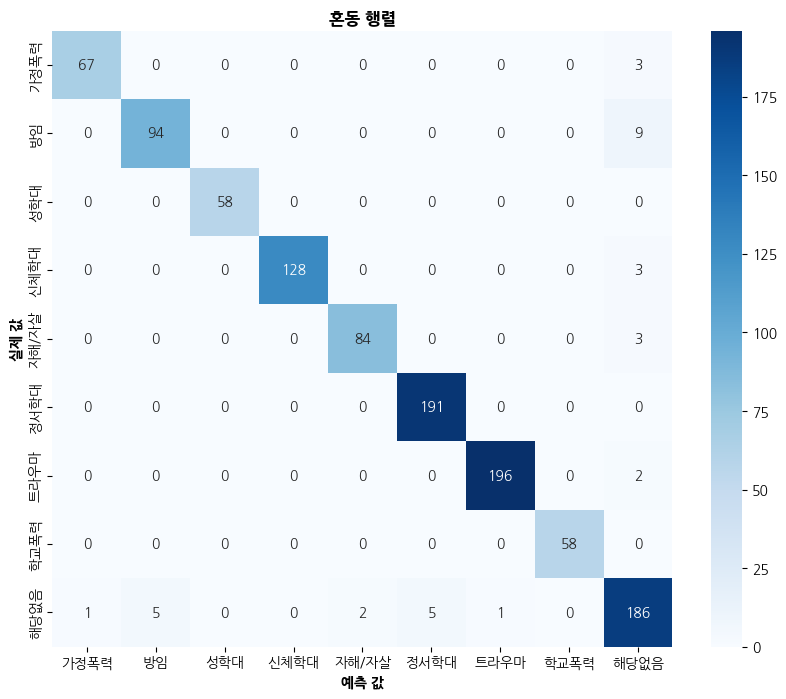

In [ ]:
# 혼동 행렬 시각화
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=label_encoder.classes_,
                     columns=label_encoder.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('실제 값', weight='bold')
plt.xlabel('예측 값', weight='bold')
plt.title('혼동 행렬', weight='bold', size=12)
plt.show()